<a href="https://colab.research.google.com/github/helmifitrayadi/retail-sales-analysis-project/blob/main/Helmi_Batch28_GrowiaIntermediate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Package

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

!pip install matplotlib_venn
from matplotlib_venn import venn2

import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import matplotlib.cm as cm

In [2]:
df_sales = pd.read_csv('/content/SalesTransactionv4a-230918-164139.csv')

In [3]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536350 entries, 0 to 536349
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionNo  536350 non-null  object 
 1   Date           536350 non-null  object 
 2   ProductNo      536350 non-null  object 
 3   ProductName    536350 non-null  object 
 4   Price          536350 non-null  float64
 5   Quantity       536350 non-null  int64  
 6   CustomerNo     536295 non-null  float64
 7   Country        536350 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 32.7+ MB


# Data Cleansing
Eksekusi 2 code dibawah ini

In [4]:
# 1. Ubah kolom Date menjadi tipe datetime
df_sales['Date'] = pd.to_datetime(df_sales['Date'])

# 2. Buang semua transaksi yang memiliki quantity negative atau yang TransactionNo diawali dengan C
df_sales = df_sales[df_sales['TransactionNo'].str[0]!='C']

In [5]:
df_sales.rename(columns={'TransactionNo':'transaction_id',
                         'Date':'date',
                         'ProductNo':'product_id',
                         'ProductName':'product_name',
                         'Quantity':'quantity',
                         'Price':'price',
                         'CustomerNo':'customer_id',
                         'Country':'country',
                         }, inplace=True)

df_eda = df_sales.copy().reset_index()

<ipython-input-5-846106b8a607>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sales.rename(columns={'TransactionNo':'transaction_id',


In [6]:
# Check NA values
nan_col = df_eda.isna().sum()
nan_row = df_eda[df_eda.isna().any(axis=1)]

print(nan_col[nan_col > 0])
nan_row

customer_id    1
dtype: int64


,index,transaction_id,date,product_id,product_name,price,quantity,customer_id,country
293806,298352,558245,2019-06-27,22734,Set Of 6 Ribbons Vintage Christmas,10.25,8,NaN,United Kingdom


In [7]:
# Drop NA values
df_eda.dropna(inplace=True)
nan_col = df_eda.isna().sum()
nan_col[nan_col > 0]

,0


In [8]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
Index: 527764 entries, 0 to 527764
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   index           527764 non-null  int64         
 1   transaction_id  527764 non-null  object        
 2   date            527764 non-null  datetime64[ns]
 3   product_id      527764 non-null  object        
 4   product_name    527764 non-null  object        
 5   price           527764 non-null  float64       
 6   quantity        527764 non-null  int64         
 7   customer_id     527764 non-null  float64       
 8   country         527764 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 40.3+ MB


# Top Contributing products

Pada retail store, ada banyak jenis barang yang dijual.
Memahami karakteristik penjualan di setiap barang sangatlah penting.  
Barang-barang dengan minat tinggi dari customer menjadi kunci bisnis untuk meraih untung.
Barang-barang dengan minat rendah dari masyarakat akan menjadi beban dari usaha apabila bisnis menyetok terlalu banyak.

Salah satu metode segmentasi yang digunakan adalah menggunakan segmentasi berdasarkan :
- Volume transaksi : Berapa banyak transaksi yang melibatkan suatu produk (Tidak mempedulikan banyaknya barang dalam 1 transaksi)
- Revenue total : Berapa dolar revenue yang dihasilkan dari penjualan produk ini.

Buatlah segmentasi produk berdasarkan volume dan revenue total dengan aturan sebagai berikut :

1. total_revenue didefinisikan sebagai perkalian harga barang dengan banyaknya pembelian
2. 20% produk dengan volume transaksi transaksi tertinggi masuk kategori "Popular". 20 - 80% Masuk kategori "Normal" dan sisanya masuk ke kategori "Low"
3. 20% produk dengan total revenue tertinggi masuk kategori "Popular". 20 - 80% Masuk kategori "Normal" dan sisanya masuk ke kategori "Low"
4. Berdasarkan penggabungan segmentasi no.2 dan no.3, apabila suatu produk Popular dari segi volume transaksi dan total revenue, maka segmentasi final dari produk tersebut adalah "Super Popular". Apabila salah satu atribut populer sementara atribut lainnya normal, maka segmentasi finalnya adalah "Popular". Apabila kedua atributnya "Low", maka segmentasi finalnya adalah "Low". Semua kombinasi lain selain yang disebutkan masuk ke kategori "Normal"

## Pertanyaan
1. Barang tipe apa yang masuk ke kategori super populer pada bulan November 2019?
2. Apakah barang yang populer di November 2019 sama dengan barang yang populer di
3. Apakah barang yang masuk kategori super populer di november sama dengan barang super populer di July ?

### Define Function

In [9]:
# Set segmentasi produk
def product_segment(df_eda):
    """
    Melakukan segmentasi produk berdasarkan volume transaksi dan total revenue.

    Args:
        df_sales (pd.DataFrame): DataFrame berisi data penjualan.

    Returns:
        pd.DataFrame: DataFrame dengan kolom segmentasi produk.
    """

    # Hitung total revenue
    df_eda['total_revenue'] = df_eda['quantity'] * df_eda['price']

    # Agregasi data per produk
    df_product_segment = df_eda.groupby('product_name').agg(total_revenue=('total_revenue', 'sum'),
                                                      volume_transaction=('transaction_id', 'count')).reset_index()

    # Set kategori
    def category_product(value, percentiles):
        if value >= percentiles.loc[0.8]: # Access using quantile number as label
            return 'Popular'
        elif value >= percentiles.loc[0.2]: # Access using quantile number as label
            return 'Normal'
        else:
            return 'Low'

    # Segmentasi by volume transaksi
    persentiles_volume = df_product_segment['volume_transaction'].quantile([0.2, 0.8])
    df_product_segment['volume_segment'] = df_product_segment['volume_transaction'].apply(lambda x: category_product(x, persentiles_volume))

    # Segementasi by total revenue
    percentiles_revenue = df_product_segment['total_revenue'].quantile([0.2, 0.8])
    df_product_segment['revenue_segment'] = df_product_segment['total_revenue'].apply(lambda x: category_product(x, percentiles_revenue))

    # Segmentasi final
    def final_segment(data):
        if data['volume_segment'] == 'Popular' and data['revenue_segment'] == 'Popular':
            return 'Super Popular'
        elif data['volume_segment'] == 'Popular' or data['revenue_segment'] == 'Popular':
            return 'Popular'
        elif data['volume_segment'] == 'Low' and data['revenue_segment'] == 'Low':
            return 'Low'
        else:
            return 'Normal'

    df_product_segment['final_segment'] = df_product_segment.apply(final_segment, axis=1)

    return df_product_segment # Added return statement outside inner functions

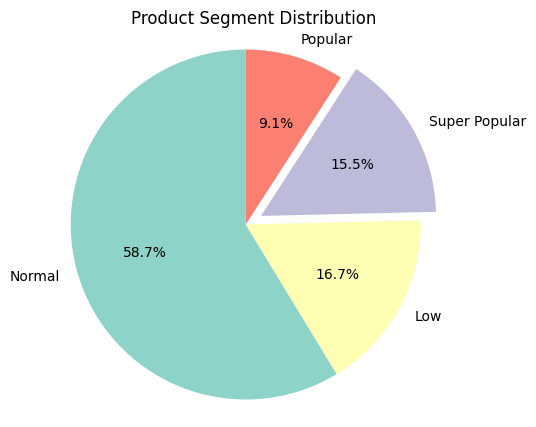

In [10]:
product_data = product_segment(df_eda)
segment_counts = product_data['final_segment'].value_counts()

labels = segment_counts.index
sizes = segment_counts.values
#colors = ['#003366', '#FFCC33', '#CC3300', '#99CCFF']  # Tentukan warna yang Anda inginkan
colors = sns.color_palette('Set3', n_colors=len(labels))
explode = (0, 0, 0.1, 0)  # Pisahkan slice 'Super Popular' untuk penekanan

# Buat pie chart
plt.figure(figsize=(5, 5))  # Tentukan ukuran pie chart
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Product Segment Distribution')
plt.axis('equal')  # Pastikan pie chart berbentuk lingkaran
plt.show()

### Super Popular Products in November 2019

In [11]:
# Filter data nov 2019
nov_2019 = df_sales[(df_sales['date'].dt.month == 11) & (df_sales['date'].dt.year == 2019)]
product_nov_2019 = product_segment(nov_2019)

# Product super popular in nov 2019
spop_products_nov_2019 = product_nov_2019[product_nov_2019['final_segment'] == 'Super Popular']

print(f"Ada {len(spop_products_nov_2019)} product Super Popular di November 2019")
spop_products_nov_2019['product_name']

<ipython-input-9-4664e7142e6e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eda['total_revenue'] = df_eda['quantity'] * df_eda['price']


Ada 437 product Super Popular di November 2019


,product_name
0,10 Colour Spaceboy Pen
5,12 Pencil Small Tube Woodland
6,12 Pencils Small Tube Red Retrospot
8,12 Pencils Tall Tube Red Retrospot
9,12 Pencils Tall Tube Skulls
...,...
2849,You're Confusing Me Metal Sign
2851,Zinc Folkart Sleigh Bells
2859,Zinc Metal Heart Decoration
2864,Zinc T-Light Holder Stars Small


In [12]:
# Top 3 super popular product november 2019
display(spop_products_nov_2019[
    ['product_name', 'total_revenue', 'volume_transaction']].
        sort_values(by=['total_revenue', 'volume_transaction'],
                ascending=False).head(3))

,product_name,total_revenue,volume_transaction
1884,Rabbit Night Light,159889.96,517
1848,Popcorn Holder,123424.90,256
1664,Paper Chain Kit 50'S Christmas,95293.96,406


**Rabbit Night Light, Popcorn Holder, dan Paper Chain Kit 50'S Christmas** adalah produk **"Super Popular"** dengan volume transaksi dan total pendapatan tertinggi di bulan November 2019.

---





### Popular Products in October vs November 2019

In [13]:
# Dataframe bulan
oct_2019 = df_sales[(df_sales['date'].dt.month == 10) & (df_sales['date'].dt.year == 2019)]
nov_2019 = df_sales[(df_sales['date'].dt.month == 11) & (df_sales['date'].dt.year == 2019)]

# Inisilisasi function pada dataframe
product_oct_2019 = product_segment(oct_2019)
product_nov_2019 = product_segment(nov_2019)

<ipython-input-9-4664e7142e6e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eda['total_revenue'] = df_eda['quantity'] * df_eda['price']
<ipython-input-9-4664e7142e6e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eda['total_revenue'] = df_eda['quantity'] * df_eda['price']


In [14]:
# Filter produk populer di Oktober dan November
pop_products_oct_2019 = product_oct_2019[product_oct_2019['final_segment'] == 'Popular'][['product_name']]
pop_products_nov_2019 = product_nov_2019[product_nov_2019['final_segment'] == 'Popular'][['product_name']]

pop_products_oct_2019.rename(columns={'product_name': 'product_name_oct'}, inplace=True)
pop_products_nov_2019.rename(columns={'product_name': 'product_name_nov'}, inplace=True)

# Grouping df with inner join
pop_product_oct_nov_19 = pd.merge(pop_products_oct_2019, pop_products_nov_2019,
                           left_on='product_name_oct', right_on='product_name_nov', how='inner')

print(f"Ada {len(pop_product_oct_nov_19)} produk Populer yang sama di Oktober dan November 2019")
pop_product_oct_nov_19

Ada 125 produk Populer yang sama di Oktober dan November 2019


,product_name_oct,product_name_nov
0,3 Piece Spaceboy Cookie Cutter Set,3 Piece Spaceboy Cookie Cutter Set
1,36 Pencils Tube Skulls,36 Pencils Tube Skulls
2,Airline Bag Vintage Tokyo 78,Airline Bag Vintage Tokyo 78
3,Angel Decoration Stars On Dress,Angel Decoration Stars On Dress
4,Ass Floral Print Multi Screwdriver,Ass Floral Print Multi Screwdriver
...,...,...
120,Wrap Paisley Park,Wrap Paisley Park
121,Wrap Pink Fairy Cakes,Wrap Pink Fairy Cakes
122,Wrap Red Vintage Doily,Wrap Red Vintage Doily
123,Wrap Vintage Doily,Wrap Vintage Doily


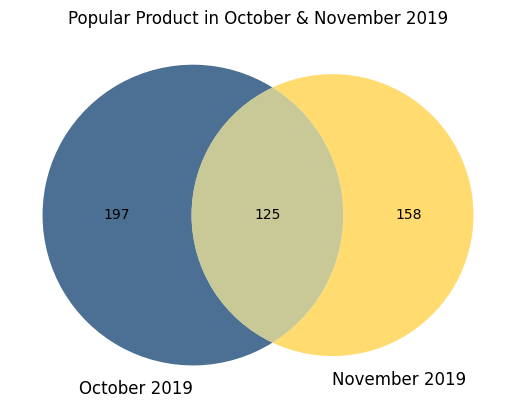

In [15]:
# Show diagram venn
venn2([set(pop_products_oct_2019['product_name_oct']),
       set(pop_products_nov_2019['product_name_nov'])],
      set_labels=('October 2019', 'November 2019'),
      set_colors=('#003366', '#FFCC33'), alpha=0.7)

plt.title('Popular Product in October & November 2019')
plt.show()

Terdapat **125 produk** yang sama-sama masuk kategori **"Popular"** di Oktober dan November 2019, menunjukkan bahwa banyak produk yang mempertahankan popularitasnya selama dua bulan tersebut.

---



### Super Popular Products in July vs November 2019

In [16]:
jul_2019 = df_sales[(df_sales['date'].dt.month == 7) & (df_sales['date'].dt.year == 2019)]
product_jul_2019 = product_segment(jul_2019)

# Filter produk super populer di Oktober dan November
spop_products_jul_2019 = product_jul_2019[product_jul_2019['final_segment'] == 'Super Popular'][['product_name']]
spop_products_nov_2019 = product_nov_2019[product_nov_2019['final_segment'] == 'Super Popular'][['product_name']]

# Rename kolom agar lebih mudah diidentifikasi
spop_products_jul_2019.rename(columns={'product_name': 'product_name_jul'}, inplace=True)
spop_products_nov_2019.rename(columns={'product_name': 'product_name_nov'}, inplace=True)

# Grouping df with inner join
spop_product_jul_nov_19 = pd.merge(spop_products_jul_2019, spop_products_nov_2019,
                           left_on='product_name_jul', right_on='product_name_nov', how='inner')

print(f"Ada {len(spop_product_jul_nov_19)} produk Super Populer yang sama di Juli dan November 2019")
spop_product_jul_nov_19

<ipython-input-9-4664e7142e6e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eda['total_revenue'] = df_eda['quantity'] * df_eda['price']


Ada 193 produk Super Populer yang sama di Juli dan November 2019


,product_name_jul,product_name_nov
0,3 Drawer Antique White Wood Cabinet,3 Drawer Antique White Wood Cabinet
1,4 Traditional Spinning Tops,4 Traditional Spinning Tops
2,6 Ribbons Rustic Charm,6 Ribbons Rustic Charm
3,60 Cake Cases Dolly Girl Design,60 Cake Cases Dolly Girl Design
4,60 Cake Cases Vintage Christmas,60 Cake Cases Vintage Christmas
...,...,...
188,Woodland Charlotte Bag,Woodland Charlotte Bag
189,World War 2 Gliders Asstd Designs,World War 2 Gliders Asstd Designs
190,You're Confusing Me Metal Sign,You're Confusing Me Metal Sign
191,Zinc Metal Heart Decoration,Zinc Metal Heart Decoration


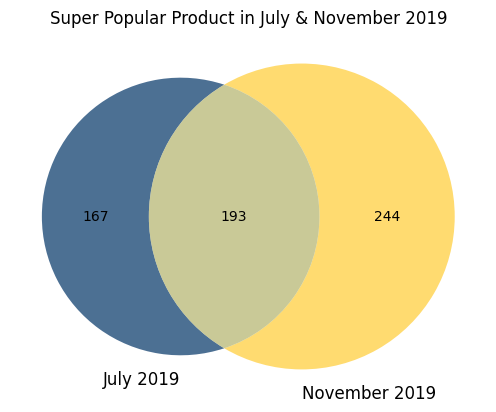

In [17]:
# Buat diagram venn
venn2([set(spop_products_jul_2019['product_name_jul']),
       set(spop_products_nov_2019['product_name_nov'])],
      set_labels=('July 2019', 'November 2019'),
      set_colors=('#003366', '#FFCC33'), alpha=0.7)

plt.title('Super Popular Product in July & November 2019')
plt.show()

Terdapat **193 produk** yang sama-sama masuk kategori **"Super Popular"** di bulan Juli dan November 2019. Hal ini menunjukkan bahwa sebagian besar produk "Super Popular" tetap konsisten selama periode tersebut.

---



# Retention Cohort Analysis

Analisis kohort adalah metode analisis yang digunakan untuk mempelajari perilaku konsumen atau pengguna dari kelompok yang sama dalam periode waktu tertentu.   
Contoh Kohort : Kohort kustomer yang bergabung pada bulan mei

Analisis retensi adalah analisis untuk melihat seberapa besar persentase pengguna atau pelanggan yang kembali menggunakan produk atau layanan dalam periode waktu tertentu.

Dengan menganalisis kohort dan retensi, perusahaan atau organisasi dapat mengidentifikasi tren dan pola dalam perilaku pengguna atau pelanggan.

Berikut cuplikan matriks retensi yang akan kalian hasilkan pada bagian ini :

![image.png](attachment:7589fe3f-aebd-4a22-bde4-b0f791dce58c.png)

Cara baca :  
Pada bulan januari, ada 827 customer baru.  
33% dari 827 customer melakukan transaksi 1 bulan kemudian.  
41.4% dari 827 customer melakukan transasksi 2 bulan kemduain.  

Hal ini menunjukkan bahwa sekitar sepertiga customer yang melanjutkan transaksi setelah mendaftar pada bulan januari.  

Sedangkan pada kohort bulan februari, ada 569 customer baru dan hanya 22% customer yang kembali bertransaksi sebulan setelahnya  

### Create Cohort Matrix

Buatlah matriks kohort retensi per bulan menggunakan data dari 1 januari 2019 hingga 30 november 2019.
1. Hitung tanggal berapa transaksi pertama customer. Disini kita menggunakna asumsi bahwa transaksi pertama pada tahun 2019 adalah transaksi pertama customer.
2. Lakukan iterasi untuk setiap bulan. Ambil berapa banyak customer yang mendaftar dan berapa banyak customer yang sama yang melakukan transaksi di bulan bulan berikutnya.

In [18]:
# Tentukan transaksi pertama customer pada tahun 2019
df_eda['first_transaction'] = df_eda.groupby('customer_id')['date'].transform('min')

# Filter dan sortir data 2019
df_eda = df_eda[(df_eda['date'] >= '2019-01-01') & (df_eda['date'] <= '2019-11-30')]

# Tentukan cohort berdasarkan bulan transaksi pertama
df_eda = df_eda[df_eda['first_transaction'] >= '2019-01-01']
df_eda['cohort_month'] = df_eda['first_transaction'].dt.to_period('M')

# Hitung jumlah customer unik per cohort
cohort_customers = df_eda.groupby('cohort_month')['customer_id'].nunique()

display(cohort_customers)

# Check unique data
total_customers = df_eda['customer_id'].nunique()
total_transactions = df_eda['transaction_id'].nunique()
total_products = df_eda['product_id'].nunique()

print(f"Total Customers: {total_customers}")
print(f"Total Transactions: {total_transactions}")
print(f"Total Unique Products: {total_products}")

,customer_id
cohort_month,
2019-01,486
2019-02,438
2019-03,503
2019-04,321
2019-05,332
2019-06,274
2019-07,211
2019-08,173
2019-09,282


Total Customers: 3645
Total Transactions: 10385
Total Unique Products: 3611


In [19]:
# Count jumlah customer yg melakukan transaksi di bulan berikutnya
retention = df_eda.groupby(['cohort_month', df_eda['date'].dt.to_period('M')])['customer_id'].nunique().reset_index()
retention['month_diff'] = (retention['date'] - retention['cohort_month']).apply(lambda x: x.n)

retention_matrix = retention.pivot_table(index='cohort_month', columns='month_diff', values='customer_id')

# Hitung persentase retensi (desimal)
retention_percentage = retention_matrix.divide(cohort_customers, axis=0)

# Tambahkan jumlah pelanggan awal per kohort
retention_percentage['new_customer'] = cohort_customers

# Ubah urutan kolom
cols = list(retention_percentage.columns)
cols.insert(0, cols.pop(cols.index('new_customer')))
retention_percentage = retention_percentage[cols]

# Tampilkan hanya 3 kolom pertama
retention_percentage

month_diff,new_customer,0,1,2,3,4,5,6,7,8,9,10
cohort_month,,,,,,,,,,,,
2019-01,486,1.0,0.201646,0.261317,0.228395,0.302469,0.279835,0.232510,0.234568,0.283951,0.316872,0.341564
2019-02,438,1.0,0.189498,0.182648,0.260274,0.262557,0.223744,0.239726,0.267123,0.235160,0.301370,NaN
2019-03,503,1.0,0.141153,0.228628,0.188867,0.230616,0.165010,0.260437,0.232604,0.284294,NaN,NaN
2019-04,321,1.0,0.205607,0.186916,0.196262,0.193146,0.230530,0.214953,0.258567,NaN,NaN,NaN
2019-05,332,1.0,0.186747,0.186747,0.165663,0.204819,0.219880,0.253012,NaN,NaN,NaN,NaN
2019-06,274,1.0,0.175182,0.149635,0.218978,0.226277,0.288321,NaN,NaN,NaN,NaN,NaN
2019-07,211,1.0,0.146919,0.175355,0.203791,0.298578,NaN,NaN,NaN,NaN,NaN,NaN
2019-08,173,1.0,0.184971,0.236994,0.225434,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09,282,1.0,0.241135,0.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


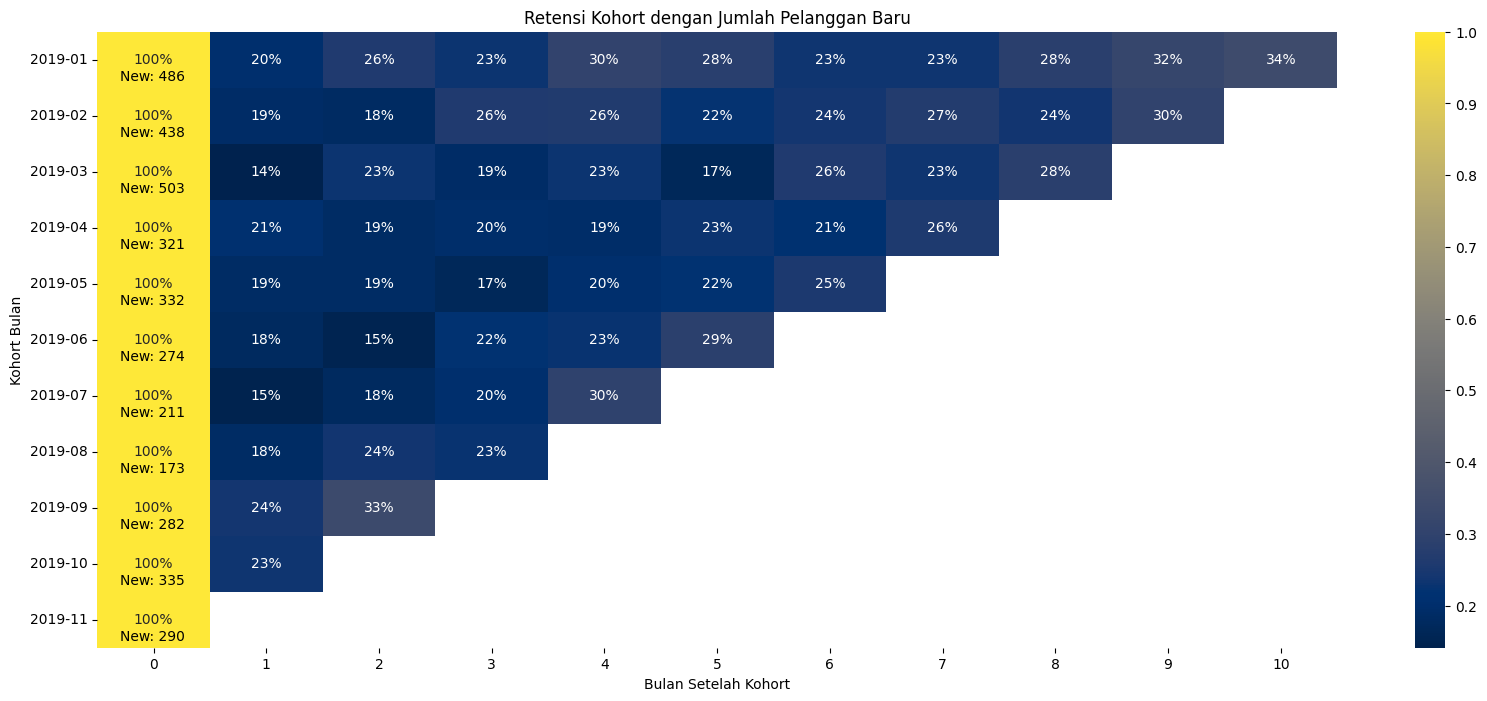

In [20]:
plt.figure(figsize=(20, 8))  # Sesuaikan ukuran gambar

# Heatmap untuk persentase retensi
sns.heatmap(retention_percentage.iloc[:, 1:], annot=True, fmt='.0%', cmap='cividis', cbar=True)

# Tambahkan anotasi untuk new_customer
for i, count in enumerate(retention_percentage['new_customer']):
    plt.text(0.2, i + 0.8, f'New: {count}', va='center', ha='left')

# Tambahkan label dan judul
plt.xlabel('Bulan Setelah Kohort')
plt.ylabel('Kohort Bulan')
plt.title('Retensi Kohort dengan Jumlah Pelanggan Baru')

# Tampilkan plot
plt.show()

### Pertanyaan 1: New Customers Growth Analysist
Bagaimana karakteristik pertumbuhan customer baru? Apakah pertumbuhan terus meningkat atau melambat?

* Jumlah pelanggan baru bervariasi dari bulan ke bulan.
* Jumlah pelanggan baru cenderung tinggi di awal tahun (Januari - Maret).
* Jumlah pelanggan baru mengalami penurunan di pertengahan tahun (April - Agustus).
* Jumlah pelanggan baru menunjukkan peningkatan di akhir tahun (September - November).

Pertumbuhan pelanggan baru tidak konsisten. Terdapat fluktuasi yang signifikan, dengan periode pertumbuhan yang kuat di awal dan akhir tahun, dan penurunan di pertengahan tahun.

### Pertanyaan 2: Cohort Retention Analysist

Setiap bulannya tim marketing menggunakan metode promosi campaign yang berbeda-beda. Bulan mana yang menghasilkan retention paling tinggi?

* Retention tertinggi terlihat pada bulan Januari 2019 dengan retensi pelanggan meningkat pada bulan ke 9 dan 10 (32%-34%).
* Bulan Februari 2019 juga menunjukkan retensi yang baik (30%), meskipun sedikit lebih rendah dari Januari.
* Bulan September 2019 juga menunjukkan retention yang cukup tinggi dalam bulan kedua setelah kohort awal (33%).
* Kohort lainnya cenderung memiliki retensi yang lebih rendah.

Januari dan Februari 2019 memiliki retensi jangka panjang yang tinggi, dengan pelanggan yang tetap bertahan hingga bulan ke-10. Begitupun dengan September 2019 memiliki retensi tinggi pada bulan kedua. Hal ini mengindikasikan bahwa metode promosi campaign yang diterapkan pada bulan-bulan tersebut mungkin sangat efektif dalam mempertahankan pelanggan.


# Time Series Analysis



### Pertanyaan 1: Time Series of Sales Revenue

Coba totalkan penjualan setiap barang per hari.   

Bagaimana trend penjualan? Apakah ada mengalami kenaikan, penurunan, atau stagnant.

In [21]:
df_eda['total_revenue'] = df_eda['quantity'] * df_eda['price']
time_series = df_eda.groupby(['date', 'product_name'])['total_revenue'].sum().reset_index()
time_series.sample(3)

,date,product_name,total_revenue
158969,2019-11-01,Vintage Glass T-Light Holder,133.20
164356,2019-11-08,Ceramic Strawberry Cake Money Bank,43.44
147017,2019-10-17,Sweetheart Ceramic Trinket Box,114.93




---


Membuat fungsi **calc_sales_trend** untuk
menganalisis data penjualan setiap produk, menghitung rata-rata penjualan 7-day rolling (setiap minggu), persentase perubahan penjualan, dan menentukan tren penjualan berdasarkan kriteria yang telah ditentukan.

In [22]:
def calc_sales_trend(time_series):
    """
    Calculates the rolling 7-day average, percentage change in sales,
    and determines the sales trend for each product.

    Args:
        df: DataFrame with 'date', 'product_name', and 'total_sales' columns.

    Returns:
        DataFrame with added 'rolling_avg_sales', 'sales_pct_change', and 'sales_trend' columns.
    """
    time_series['rolling_avg_sales'] = time_series.groupby('product_name')['total_revenue'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
    time_series['sales_pct_change'] = time_series.groupby('product_name')['total_revenue'].transform(lambda x: x.pct_change())

    def determine_trend(row):
        if pd.isna(row['sales_pct_change']):
            return 'stagnant'
        if row['sales_pct_change'] > 0.1 and row['rolling_avg_sales'] > row['total_revenue']:
            return 'increasing'
        elif row['sales_pct_change'] < -0.1 and row['rolling_avg_sales'] < row['total_revenue']:
            return 'decreasing'
        else:
            return 'stagnant'

    time_series['sales_trend'] = time_series.apply(determine_trend, axis=1)
    return time_series

In [23]:
time_series = calc_sales_trend(time_series)
time_series.sample(5)

,date,product_name,total_revenue,rolling_avg_sales,sales_pct_change,sales_trend
51298,2019-04-21,Lunch Bag Dolly Girl Design,26.42,54.147143,-0.778727,stagnant
183577,2019-11-28,Beaded Crystal Heart Green On Stick,78.67,32.164286,4.923946,stagnant
100369,2019-08-02,60 Teatime Fairy Cake Cases,270.97,326.872857,22.501301,increasing
22578,2019-02-21,Feltcraft 6 Flower Friends,74.40,127.324286,-0.382008,stagnant
70203,2019-06-07,Childrens Cutlery Spaceboy,58.00,116.000000,-0.750000,stagnant




---
Menentukan tren dengan membandingkan pendapatan pada hari pertama dan terakhir dalam periode yang dianalisis. Ini didasarkan pada asumsi bahwa jika pendapatan di akhir periode lebih tinggi daripada di awal periode, maka tren penjualan secara keseluruhan cenderung meningkat.



In [24]:
# Group data by date and sum total revenue
daily_revenue = time_series.groupby('date')['total_revenue'].sum()

# Analyze the trend (simple approach: check the first and last values)
first_day_revenue = daily_revenue.iloc[0]
last_day_revenue = daily_revenue.iloc[-1]

if last_day_revenue > first_day_revenue:
    trend = "increasing"
elif last_day_revenue < first_day_revenue:
    trend = "decreasing"
else:
    trend = "stagnant"

print(f"The overall trend of daily sales is: {trend}")

The overall trend of daily sales is: increasing




---

* Mengidentifikasi periode di mana penjualan harian mengalami fluktuasi yang signifikan, yaitu penjualan yang jauh lebih tinggi atau lebih rendah dari biasanya.
* Dengan membandingkan data penjualan dengan rolling mean dan standard deviation. Rolling mean digunakan untuk menghaluskan fluktuasi acak dan standard deviation digunakan untuk menentukan batas normal.
* Data penjualan yang berada di luar batas normal dianggap sebagai fluktuasi yang signifikan dan perlu diinvestigasi lebih lanjut.

In [25]:
# Look for significant fluctuations
# Calculate rolling mean to smooth out daily fluctuations
rolling_mean = daily_revenue.rolling(window=7).mean() #7-day rolling mean

# Find periods of unusually high or low sales
std_dev = daily_revenue.std()
upper_bound = rolling_mean + 2 * std_dev
lower_bound = rolling_mean - 2 * std_dev

# Identify significant fluctuations
fluctuations = daily_revenue[(daily_revenue > upper_bound) | (daily_revenue < lower_bound)]

if not fluctuations.empty:
    print("Significant fluctuations in daily sales were detected:")
    display(fluctuations)
else:
    print("\nNo significant fluctuations in daily sales were detected.")

Significant fluctuations in daily sales were detected:


,total_revenue
date,
2019-01-18,897341.30
2019-04-18,282429.53
2019-08-18,268045.00
2019-11-14,395044.85




---
Membuat visualisasi data penjualan harian dan tren penjualan menggunakan lineplot. Dengan menampilkan data penjualan harian dan rolling mean dalam satu grafik, kita dapat dengan mudah melihat pola dan fluktuasi penjualan dari waktu ke waktu.

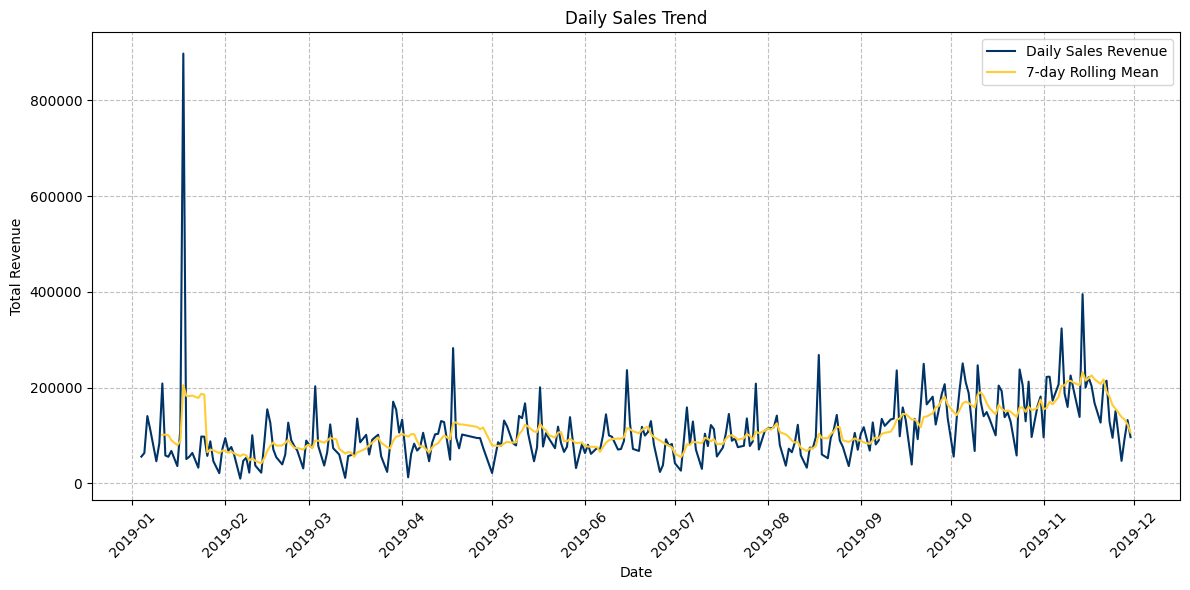

In [26]:
# Plot data penjualan harian
plt.figure(figsize=(12, 6))
plt.plot(daily_revenue.index, daily_revenue.values, label='Daily Sales Revenue', color='#003366')

# Tambahkan rolling mean
plt.plot(rolling_mean.index, rolling_mean.values, label='7-day Rolling Mean', color='#FFCC33')

# Label dan judul
plt.xlabel('Date')
plt.ylabel('Total Revenue')
plt.title('Daily Sales Trend')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.8)
plt.tight_layout()
plt.show()

Berdasarkan visualisasi lineplot Daily  Sales Trend sepanjang 2019, berikut analisisnya:

* Daily Sales Revenue menunjukkan fluktuasi harian yang tinggi, terutama pada januari 2019, dimana menandakan variasi signifikan dalam pendapatan dari hari ke hari.

* 7-day Rolling Mean menunjukkan tren yang relatif stabil sepanjang tahun setelah lonjakan awal. Ini menandakan meskipun Daily Sales Revenue berfluktuasi, tren keseluruhan tetap stabil.

**Conclusion**

Visualisasi ini menunjukkan bahwa Daily Sales Revenue pada tahun 2019 mengalami fluktuasi yang tinggi, tetapi tren keseluruhan relatif stabil setelah lonjakan awal di bulan Januari. 7-day Rolling Mean membantu mengidentifikasi tren umum dan mengurangi dampak fluktuasi harian.

### Pertanyaan 2: Day of Week Seasonality

Lakukan analisis seasonality dengan melihat total order per harinya dari Senin hingga Minggu.

In [27]:
time_series['day_of_week'] = time_series['date'].dt.day_name()
daily_orders = time_series.groupby('day_of_week')['total_revenue'].sum().reset_index()

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_orders['day_of_week'] = pd.Categorical(daily_orders['day_of_week'], categories=day_order, ordered=True)
daily_orders = daily_orders.sort_values('day_of_week').set_index('day_of_week')
daily_orders

,total_revenue
day_of_week,
Monday,4419944.38
Wednesday,2879049.61
Thursday,5243867.81
Friday,6653827.18
Saturday,5242297.19
Sunday,6145318.81




---


Buat visualisasi yang menunjukkan **Total Revenue
per Day of Week**. Sumbu x menunjukkan hari dalam seminggu (Senin-Minggu), dan sumbu y menunjukkan total pendapatan. Tinggi setiap bar merepresentasikan total pendapatan pada hari tersebut.

<ipython-input-28-807144ff76b3>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=daily_orders, x='day_of_week', y='total_revenue', palette='Set3')


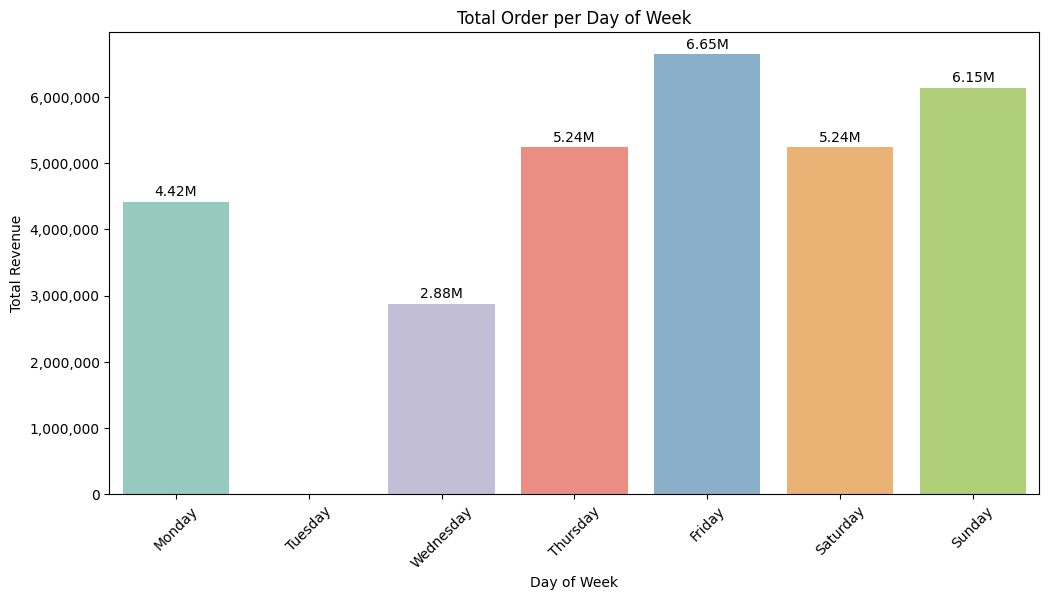

In [28]:
# Gunakan palette warna yang soft
# Buat barplot
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=daily_orders, x='day_of_week', y='total_revenue', palette='Set3')

# Fungsi untuk memformat label nilai
def format_label(value):
    if value >= 1000000:
        return f'{value / 1000000:.2f}M'  # Format dalam jutaan (M)
    elif value >= 1000:
        return f'{value / 1000:.0f}K'    # Format dalam ribuan (K)
    else:
        return f'{value:.0f}'           # Format angka biasa

# Add label nilai di atas setiap bar dengan format yang lebih ringkas
for p in ax.patches:
    height = p.get_height()
    ax.annotate(format_label(height), (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', xytext=(0, 7), textcoords='offset points')

plt.title('Total Order per Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
#plt.tight_layout()

# Format sumbu y dengan angka asli
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

plt.show()

**Conclusions:**

* Tren ini menunjukkan bahwa pelanggan lebih aktif melakukan pemesanan menjelang akhir pekan, terutama pada Jumat dan Minggu.
* Pertengahan minggu (terutama Rabu) tampaknya menjadi titik rendah dalam jumlah pesanan.
* Jika tujuan bisnis adalah meningkatkan penjualan pada hari-hari lemah seperti Rabu, strategi promosi atau diskon dapat diterapkan untuk menarik lebih banyak pesanan.

# Price Elasticity

Price sensitivity atau sensitifitas harga mengacu pada perubahan permintaan pelanggan akibat naik atau turunya harga suatu produk.

Pada bagian ini anda akan diminta untuk melakukan analisis terhadap suatu produk yang penjualannya sangat dipengaruhi oleh harga.

### Pertanyaan 1 : Count Unique Price Change Products
Produk apa yang paling sering mengalami perubahan harga?   
Hitunglah banyaknya harga unik di setiap produk dan ambil daftar produk yang pernah terjual dengan setidaknya 10 variasi harga yang berbeda.

Price Elasticity akan semakin baik dianalisis ketika lebih banyak variasi harga yang muncul.

In [29]:
# Group by product_name and get the number of unique prices
unique_prices = df_sales.groupby('product_name')['price'].nunique().reset_index()

# Rename the columns for clarity
unique_prices.rename(columns={'price': 'unique_price_count'}, inplace=True)

# Filter products with at least 10 unique prices
filtered_products = unique_prices[unique_prices['unique_price_count'] >= 10]

# Display the result
display(filtered_products)

,product_name,unique_price_count
6,12 Message Cards With Envelopes,11
7,12 Pencil Small Tube Woodland,11
8,12 Pencils Small Tube Red Retrospot,10
18,15cm Christmas Glass Ball 20 Lights,12
25,20 Dolly Pegs Retrospot,10
...,...,...
3670,World War 2 Gliders Asstd Designs,10
3733,Zinc Folkart Sleigh Bells,11
3738,Zinc Heart Lattice T-Light Holder,10
3743,Zinc Metal Heart Decoration,10


### Pertanyaan 2 : Correlation Between Price and Quantity

Dari semua produk yang terambil dari step 1, hitung lah korelasi antara harga dengan quantity untuk setiap barang.  
Barang manakah yang memiliki korelasi paling negatif?  

In [30]:
# Calculate correlation for each product
correlations = {}
for product in filtered_products['product_name']:
    product_corr = df_eda[df_eda['product_name'] == product]
    correlation = product_corr['price'].corr(product_corr['quantity'])
    correlations[product] = correlation

# Convert to DataFrame for easier viewing
df_product_corr = pd.DataFrame(list(correlations.items()), columns=['product_name', 'correlation'])

# Find the product with the most negative correlation
most_negative_product = df_product_corr.loc[df_product_corr['correlation'].idxmin()]

# Display the result
print(f"The product with the most negative correlation is: {most_negative_product['product_name']}")
print(f"Correlation value: {most_negative_product['correlation']}")

# Display the result
#display(df_product_corr)
#isplay(df_product_corr.sort_values(by='correlation').head())

df_product_corr_head = df_product_corr.sort_values(by='correlation').head()
df_product_corr_head

The product with the most negative correlation is: Doorstop Racing Car Design
Correlation value: -0.635425397194417


,product_name,correlation
196,Doorstop Racing Car Design,-0.635425
662,Vip Passport Cover,-0.576675
222,French Paisley Cushion Cover,-0.558805
400,Pastel Colour Honeycomb Fan,-0.557261
311,Large Cake Towel Pink Spots,-0.504255


<ipython-input-31-25813ca6d8f0>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='product_name', x='correlation', data=df_product_corr_head, palette='cividis')


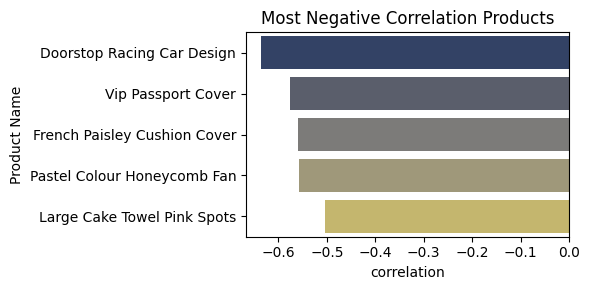

In [31]:
plt.figure(figsize=(6, 3))
sns.barplot(y='product_name', x='correlation', data=df_product_corr_head, palette='cividis')

plt.title('Most Negative Correlation Products')
plt.ylabel('Product Name')
plt.tight_layout()
#plt.gca().axes.get_xaxis().set_visible(False)
plt.show()

### Pertanyaan 3 : Viz & Analyzing The Most Negative Product
Buatlah scatter plot antara harga dan quantity untuk barang dari soal sebelumnya.  
Apabila produk tersebut mengalami kenaikan harga, kira-kira apa yang akan terjadi dengan penjualan ?

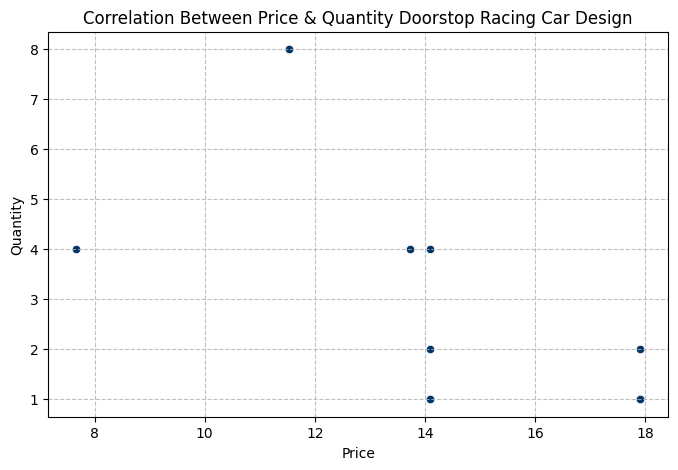

In [32]:
product_corr_min = df_eda[df_eda['product_name'] == 'Doorstop Racing Car Design']

# scatter plot
plt.figure(figsize=(8, 5))  # Atur ukuran plot
#sns.set_style("whitegrid")
sns.scatterplot(x='price', y='quantity', data=product_corr_min, color='#003366')
plt.title('Correlation Between Price & Quantity Doorstop Racing Car Design')
plt.xlabel('Price')
plt.ylabel('Quantity')
plt.grid(True, linestyle='--', alpha=0.8)
#plt.tight_layout()
plt.show()

Berdasarkan scatter plot yang menunjukkan hubungan antara harga dan jumlah produk terjual, berikut adalah analisisnya:

**1. Tren Umum**
* Tampaknya ada kecenderungan bahwa ketika harga lebih rendah (sekitar 8-12), jumlah yang terjual lebih tinggi (terlihat dari titik dengan kuantitas 4 dan 8).
* Ketika harga naik ke sekitar 14-18, jumlah yang terjual lebih bervariasi, tetapi lebih banyak titik yang menunjukkan kuantitas rendah (1 atau 2).

**2. Prediksi Jika Harga Naik**
* Jika harga dinaikkan lebih jauh dari kisaran saat ini (misalnya, di atas 18), kemungkinan jumlah produk yang terjual akan menurun lebih lanjut.
* Konsumen cenderung lebih sensitif terhadap harga, terutama jika terdapat alternatif yang lebih murah di pasar.

**3. Strategi yang Bisa Diterapkan**
* Jika kenaikan harga tidak bisa dihindari, pastikan ada peningkatan nilai yang dirasakan pelanggan, seperti peningkatan kualitas atau layanan tambahan.
* Jika tujuan utama adalah meningkatkan volume penjualan, mempertahankan harga di kisaran lebih rendah (sekitar 10-12) mungkin lebih efektif.
* Melakukan uji coba diskon atau promo untuk melihat apakah penjualan bisa meningkat dengan harga tertentu.

Kemungkinan besar, kenaikan harga produk **"Doorstop Racing Car Design"** akan menyebabkan **penurunan penjualan**. Namun, besarnya penurunan tersebut akan tergantung pada beberapa faktor, seperti elastisitas harga permintaan, keunikan produk, dan persepsi konsumen terhadap nilai produk.

# Basket Size Analysis

Ketika seorang pelanggan e-commerce menekan "add to cart", maka barang tersebut akan disimpan dalam sebuah "basket".  
Ketika melakukan checkout, maka semua barang dalam basket tersebut akan diproses dan dikirimkan.  
Ukuran dari basket dapat diukur melalui nilai GMV (Gross merchandise volume) yang merupakan total harga barang yang dibeli.  
Contoh :
Pada tanggal 1 januari 2012
Tuan A membeli 1 shampoo seharga 15ribu dan 2 sabun seharga 20ribu masing-masing. Maka basket size tuan A adalah 55ribu rupiah.
Nyonya B hanya membeli 1 cemilan seharga 20 ribu, maka basket size dari nyonya B adalah 20 ribu rupiah.
Berarti total GMV ecommerce pada 1 januari 2012 adalah 75ribu rupiah, dengan rata-rata basket size sebesar 37.5 ribu rupiah per basket.


### Pertanyaan 1: Time Series of Basket Size (Avg)
Hitung rata-rata basket size dari seluruh transaksi per harinya, apakah konsisten atau ada perubahan?

In [33]:
daily_avg_basket = df_eda.groupby('date')['quantity'].mean().reset_index()
daily_avg_basket = daily_avg_basket.rename(columns={'quantity': 'avg_basket_size'})
daily_avg_basket = daily_avg_basket.set_index('date')

daily_avg_basket.sort_values(by='avg_basket_size', ascending=False).head()

,avg_basket_size
date,
2019-01-18,75.733910
2019-06-15,28.853933
2019-08-18,25.937637
2019-02-10,22.071782
2019-04-01,18.330709


count    277.000000
mean       9.196682
std        5.264170
min        2.841286
25%        6.622020
50%        8.299293
75%       10.683995
max       75.733910
Name: avg_basket_size, dtype: float64 



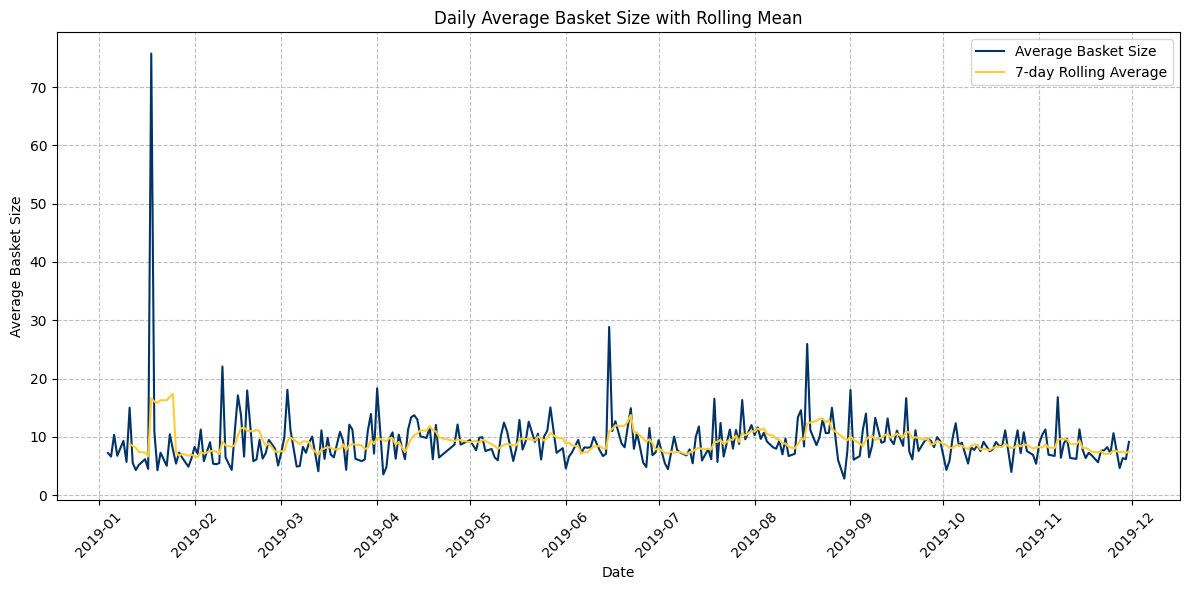


Percentage change in average basket size (2019 H1 vs H2): -2.70%


In [34]:
# Show statistic desc
print(daily_avg_basket['avg_basket_size'].describe(), f"\n")

# Visualisasi time series with a rolling avg
plt.figure(figsize=(12, 6))
plt.plot(daily_avg_basket.index, daily_avg_basket['avg_basket_size'], label='Average Basket Size', color='#003366')

daily_avg_basket['rolling_avg'] = daily_avg_basket['avg_basket_size'].rolling(window=7).mean()
plt.plot(daily_avg_basket.index, daily_avg_basket['rolling_avg'], label='7-day Rolling Average', color='#FFCC33')

plt.xlabel('Date')
plt.ylabel('Average Basket Size')
plt.title('Daily Average Basket Size with Rolling Mean')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.8)
plt.show()

# Calculate percentage change over specific periods
start_date_2019 = '2019-01-01'
end_date_2019 = '2019-11-30'

try:
    df_2019 = daily_avg_basket.loc[start_date_2019:end_date_2019]
    first_half_2019 = df_2019.loc[:'2019-06-30']['avg_basket_size'].mean()
    second_half_2019 = df_2019.loc['2019-07-01':]['avg_basket_size'].mean()
    percentage_change_2019 = ((second_half_2019 - first_half_2019) / first_half_2019) * 100
    print(f"\nPercentage change in average basket size (2019 H1 vs H2): {percentage_change_2019:.2f}%")
except KeyError:
    print("\nError: Date range not found in the DataFrame.")
except Exception as e:
    print(f"\nAn unexpected error occurred: {e}")

Berdasarkan visualisasi time series Daily Average Basket Size with Rolling Mean sepanjang 2019, berikut analisisnya:

* Average Basket Size menunjukkan variabilitas, dengan **standard deviasi sekitar 5.26**. Ada hari-hari dengan lonjakan tajam, yang mungkin disebabkan oleh promosi khusus, hari libur, atau faktor lainnya.
* Plot time series dengan 7-day Rolling Average memberikan gambaran tren yang lebih halus dan menghilangkan fluktuasi harian yang ekstrem.
* Percentage change in Average Basket Size, menunjukkan bahwa rata-rata Basket Size Item pada paruh kedua tahun 2019 (H2) mengalami **penurunan sebesar 2.70%** dibandingkan dengan paruh pertama tahun 2019 (H1).

### Pertanyaan 2: Average Basket Size by Country
Apakah ada perbedaan ukuran basket dari negara yang berbeda?

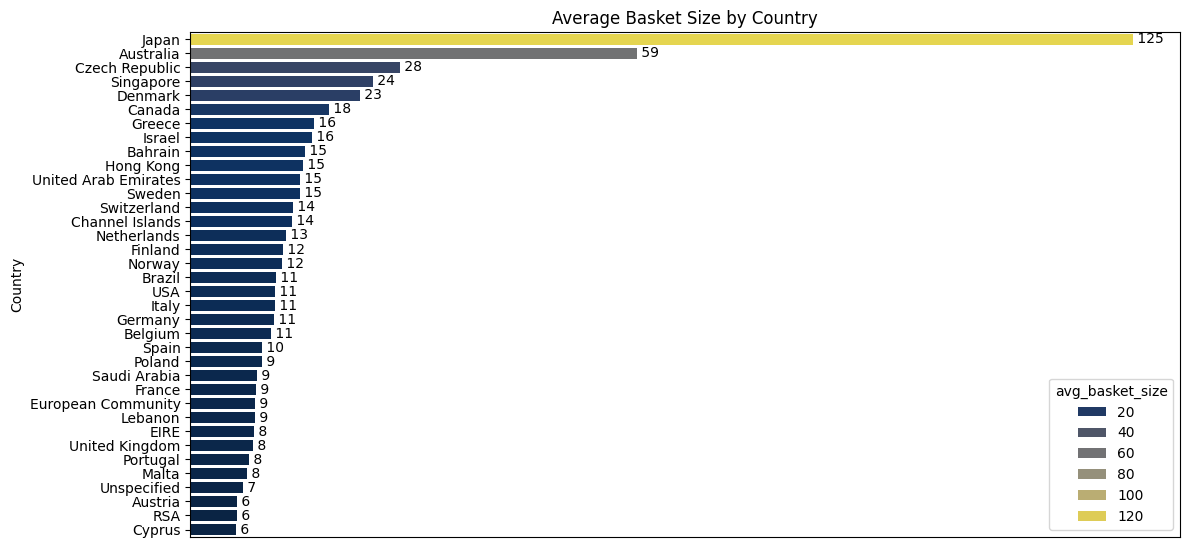

In [35]:
country_avg_basket = df_eda.groupby('country')['quantity'].mean().reset_index()
country_avg_basket = country_avg_basket.rename(columns={'quantity': 'avg_basket_size'})
country_avg_basket = country_avg_basket.sort_values(by='avg_basket_size', ascending=False)

plt.figure(figsize=(12, 6))
ax = sns.barplot(y='country', x='avg_basket_size', palette='cividis', hue='avg_basket_size', data=country_avg_basket)

for p in ax.containers[0:]:
    ax.bar_label(p, fmt=' %.f')

plt.ylabel('Country')
plt.title('Average Basket Size by Country')
plt.xlabel('Average Basket Size')
plt.ylabel('Country')
#plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.gca().axes.get_xaxis().set_visible(False)
plt.show()

* Barplot Average Basket Size by Country ini secara jelas menunjukkan adanya variasi yang signifikan dalam ukuran keranjang belanja rata-rata di berbagai negara.
* Jepang menonjol dengan ukuran keranjang belanja yang jauh lebih besar dibandingkan negara lain. Selain itu, negara-negara Eropa cenderung memiliki ukuran keranjang belanja yang lebih rendah dibandingkan negara-negara di benua lain.
* Perbedaan ini kemungkinan disebabkan oleh faktor-faktor seperti budaya belanja, kondisi ekonomi, kebiasaan konsumen, dan jenis barang yang dibeli.

# Crucial Question

Ini adalah 5 pertanyaan utama yang ditanyakan oleh pembuat dataset sales ini.  
Anda dapat menggunakan analisis yang sudah dikerjakan pada bagian sebelumnya, ataupun melakukan analisis baru untuk menjawab pertanyaan dibawah.

1. How was the sales trend over the months?
2. What are the most frequently purchased products?
3. How many products does the customer purchase in each transaction?
4. What are the most profitable segment customers?
5. Based on your findings, what strategy could you recommend to the business to gain more profit?

### 1: How was the sales trend over the months?

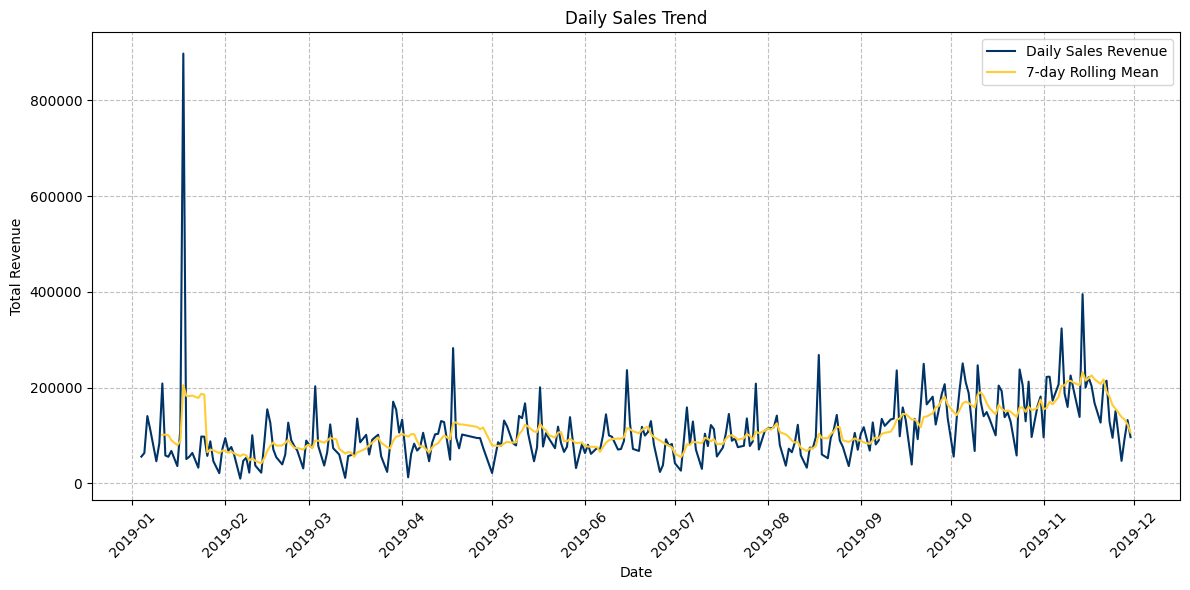

In [36]:
# Plot data penjualan harian
plt.figure(figsize=(12, 6))
plt.plot(daily_revenue.index, daily_revenue.values, label='Daily Sales Revenue', color='#003366')

# Tambahkan rolling mean
plt.plot(rolling_mean.index, rolling_mean.values, label='7-day Rolling Mean', color='#FFCC33')

# Label dan judul
plt.xlabel('Date')
plt.ylabel('Total Revenue')
plt.title('Daily Sales Trend')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.8)
plt.tight_layout()
plt.show()

* Tren penjualan keseluruhan menunjukkan adanya lonjakan awal dalam penjualan di bulan Januari, diikuti oleh stabilisasi dan pertumbuhan bertahap dengan peningkatan yang mencolok di bagian akhir tahun.

* Retensi selama campaign promosi tertentu berdampak positif pada pola penjualan, dimana retensi paling konsisten dan tinggi adalah bulan Januari dan retensi terburuk ada pada bulan Maret. Sementara itu, retensi September menunjukkan hasil yang cukup baik pada bulan pertama, mengindikasikan potensi pertumbuhan retensi di masa mendatang.

### 2: What are the most frequently purchased products?

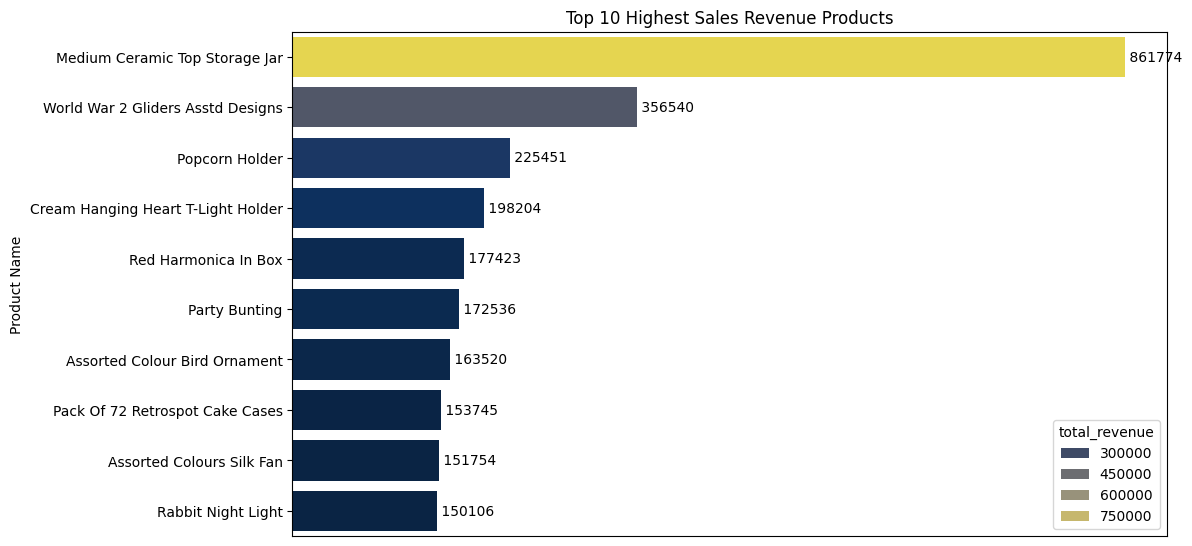

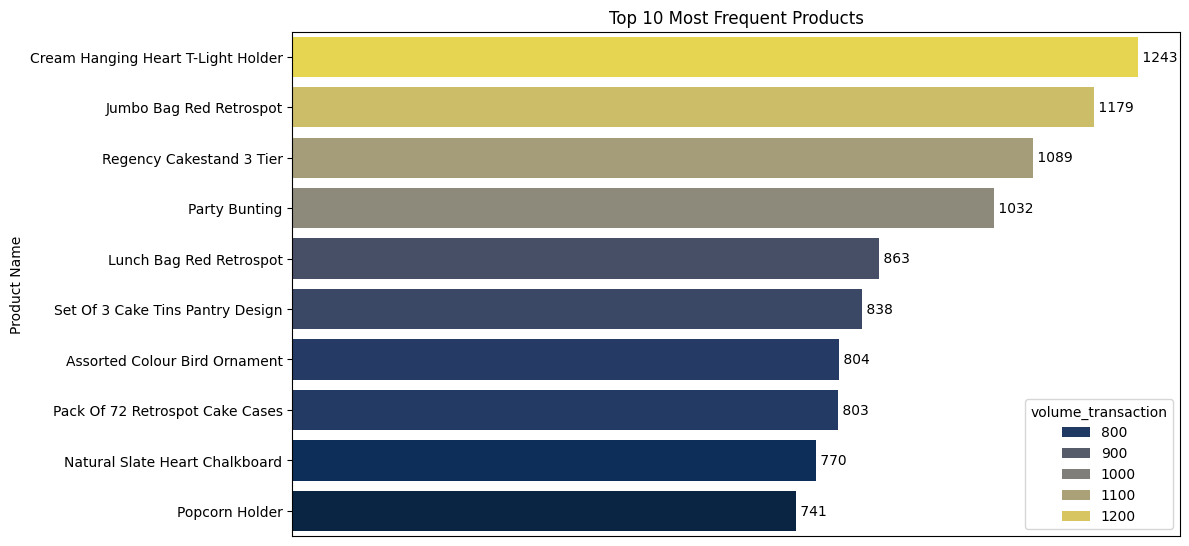

In [37]:
product_data = product_segment(df_eda)

# Top Sales Product
top_revenue_products = product_data.sort_values(by='total_revenue', ascending=False).head(10)
plt.figure(figsize=(12, 6))
ax = sns.barplot(y='product_name', x='total_revenue', hue='total_revenue', data=top_revenue_products, palette='cividis')

for p in ax.containers:
  ax.bar_label(p, fmt=' %.f')

plt.xlabel('q')
plt.ylabel('Product Name')
plt.title('Top 10 Highest Sales Revenue Products')
plt.tight_layout()
plt.gca().axes.get_xaxis().set_visible(False)
plt.show()

# Top frequent product
top_frequent_products = product_data.sort_values(by='volume_transaction', ascending=False).head(10)
#print(most_frequent_products[['product_name', 'volume_transaction']], '\n')
plt.figure(figsize=(12, 6))
ax = sns.barplot(y='product_name', x='volume_transaction', hue='volume_transaction', data=top_frequent_products, palette='cividis')

for p in ax.containers:
  ax.bar_label(p, fmt=' %.f')

plt.xlabel('q')
plt.ylabel('Product Name')
plt.title('Top 10 Most Frequent Products')
plt.tight_layout()
plt.gca().axes.get_xaxis().set_visible(False)
plt.show()

### 3: How many products does the customer purchase in each transaction?

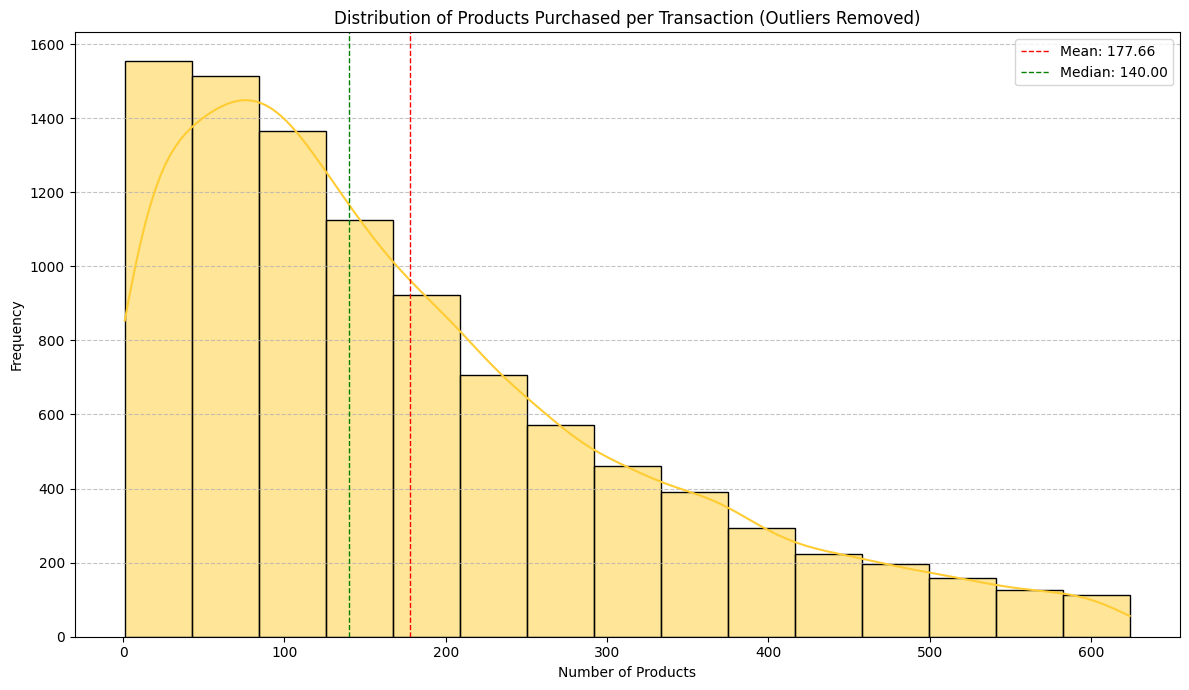

In [38]:
transaction_quantity = df_eda.groupby('transaction_id')['quantity'].sum().reset_index()

# Hitung IQR untuk menangani outlier
Q1 = transaction_quantity['quantity'].quantile(0.25)
Q3 = transaction_quantity['quantity'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter outlier
filtered_transaction_quantity = transaction_quantity[(transaction_quantity['quantity'] >= lower_bound) &
                                                     (transaction_quantity['quantity'] <= upper_bound)]

# Tentukan jumlah bins menggunakan aturan Sturges atau Freedman-Diaconis
n = len(filtered_transaction_quantity['quantity'])
k = int(np.ceil(np.log2(n) + 1))  # Aturan Sturges
# Atau gunakan aturan Freedman-Diaconis
# bin_width = 2 * IQR / (n ** (1/3))
# k = int((filtered_transaction_quantity['quantity'].max() - filtered_transaction_quantity['quantity'].min()) / bin_width)

# Visualisasi
plt.figure(figsize=(12, 7))
sns.histplot(filtered_transaction_quantity['quantity'], bins=k, kde=True, color='#FFCC33')

# Tambahkan garis rata-rata dan median
mean_val = filtered_transaction_quantity['quantity'].mean()
median_val = filtered_transaction_quantity['quantity'].median()
plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_val:.2f}')
plt.axvline(median_val, color='green', linestyle='dashed', linewidth=1, label=f'Median: {median_val:.2f}')

plt.title('Distribution of Products Purchased per Transaction (Outliers Removed)')
plt.xlabel('Number of Products')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.75)
plt.tight_layout()
plt.show()

Histogram ini memberikan gambaran yang jelas dan ringkas tentang pola pembelian pelanggan. Sebagian besar pelanggan membeli antara 0 hingga 100 produk dalam setiap transaksi. Namun, ada beberapa transaksi dengan jumlah produk yang lebih banyak, bahkan hingga lebih dari 600 produk. Secara rata-rata, pelanggan membeli sekitar 177 produk, tetapi nilai tengahnya adalah 140 produk. Ini menunjukkan bahwa distribusi pembelian produk miring ke kanan, artinya ada beberapa transaksi dengan jumlah produk yang sangat tinggi.

### 4: What are the most profitable segment customers?

Karena dataset yang digunakan tidak menyertakan informasi biaya / cost, maka kita akan fokus pada total revenue sebagai bentuk profitabilitas.

In [39]:
def customer_segment(df_eda):
    """
    Melakukan segmentasi pelanggan berdasarkan total pengeluaran dan frekuensi pembelian.

    Args:
        df_sales (pd.DataFrame): DataFrame berisi data penjualan.

    Returns:
        pd.DataFrame: DataFrame dengan kolom segmentasi pelanggan.
    """

    # Agregasi data per pelanggan
    df_customer_segment = df_eda.groupby('customer_id').agg(
        total_spending=('total_revenue', 'sum'),
        purchase_frequency=('transaction_id', 'count')
    ).reset_index()

    # Set kategori
    def category_customer(value, percentiles):
        if value >= percentiles.loc[0.8]:  # Access using quantile number as label
            return 'High Value'
        elif value >= percentiles.loc[0.2]:  # Access using quantile number as label
            return 'Medium Value'
        else:
            return 'Low Value'

    # Segmentasi by total spending
    percentiles_spending = df_customer_segment['total_spending'].quantile([0.2, 0.8])
    df_customer_segment['spending_segment'] = df_customer_segment['total_spending'].apply(
        lambda x: category_customer(x, percentiles_spending)
    )

    # Segmentasi by purchase frequency
    percentiles_frequency = df_customer_segment['purchase_frequency'].quantile([0.2, 0.8])
    df_customer_segment['frequency_segment'] = df_customer_segment['purchase_frequency'].apply(
        lambda x: category_customer(x, percentiles_frequency)
    )

    # Segmentasi final
    def final_segment(data):
        if data['spending_segment'] == 'High Value' and data['frequency_segment'] == 'High Value':
            return 'Champion'
        elif data['spending_segment'] == 'High Value' or data['frequency_segment'] == 'High Value':
            return 'Loyal'
        elif data['spending_segment'] == 'Low Value' and data['frequency_segment'] == 'Low Value':
            return 'Churned'
        else:
            return 'Regular'

    df_customer_segment['final_segment'] = df_customer_segment.apply(final_segment, axis=1)

    return df_customer_segment

In [40]:
# Segmentasi pelanggan
customer_segments = customer_segment(df_eda)
df_eda = pd.merge(df_eda, customer_segments[['customer_id', 'final_segment']], on='customer_id')
segment_profit = df_eda.groupby('final_segment')['total_revenue'].sum().reset_index()

In [41]:
customer_segments.head(10)

,customer_id,total_spending,purchase_frequency,spending_segment,frequency_segment,final_segment
0,12004.0,1509.60,56,Medium Value,Medium Value,Regular
1,12006.0,24.76,1,Low Value,Low Value,Churned
2,12008.0,5689.57,203,Medium Value,High Value,Loyal
3,12024.0,149.52,5,Low Value,Low Value,Churned
4,12025.0,1021.59,46,Low Value,Medium Value,Regular
5,12026.0,20486.32,409,High Value,High Value,Champion
6,12031.0,136.18,7,Low Value,Low Value,Churned
7,12042.0,6296.77,223,Medium Value,High Value,Loyal
8,12043.0,1235.59,36,Low Value,Medium Value,Regular
9,12050.0,141.67,10,Low Value,Low Value,Churned


<ipython-input-42-92f83045cf62>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='final_segment', y='total_revenue', data=segment_profit, palette='Set2')


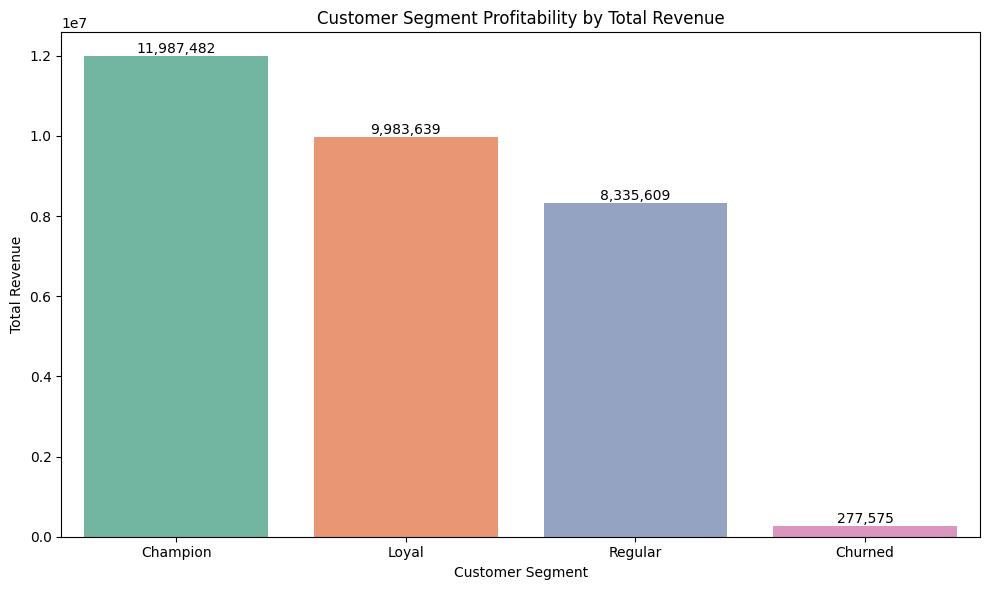

In [42]:
segment_profit = segment_profit.sort_values(by='total_revenue', ascending=False)
#display(segment_profit)

# Visualisasi menggunakan barplot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='final_segment', y='total_revenue', data=segment_profit, palette='Set2')

for p in ax.containers[0:]:
    ax.bar_label(p, fmt='{:,.0f}')

#def format_y_axis(x, pos):
#    return '{:,.0f}'.format(x)  # Format dengan pemisah ribuan dan 0 desimal

# Mengatur formatter pada sumbu Y
#plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_y_axis))

plt.title('Customer Segment Profitability by Total Revenue')
plt.xlabel('Customer Segment')
plt.ylabel('Total Revenue')
plt.tight_layout()
#plt.gca().axes.get_yaxis().set_visible(False)
plt.show()

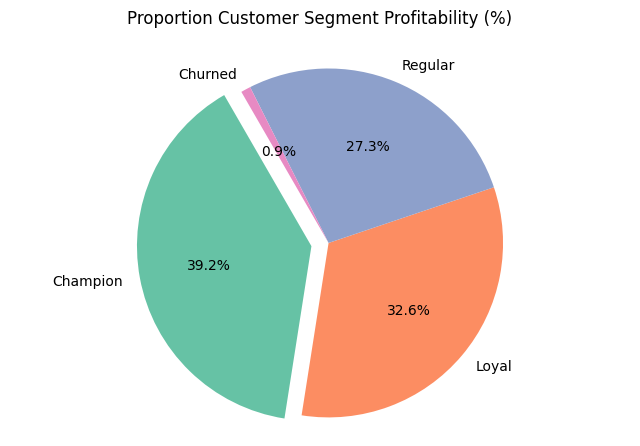

In [43]:
sizes = segment_profit['total_revenue'].values
labels = segment_profit['final_segment'].values
#labels = segment_profit.index
#sizes = segment_profit.values
#colors = ['#003366', '#FFCC33', '#CC3300', '#99CCFF']  # Tentukan warna yang Anda inginkan
colors = sns.color_palette('Set2', n_colors=len(labels))
explode = (0.1, 0, 0, 0)  # Pisahkan slice 'Super Popular' untuk penekanan

# Buat pie chart
plt.figure(figsize=(8, 5))  # Tentukan ukuran pie chart
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=120)
plt.title('Proportion Customer Segment Profitability (%)', pad=20)
plt.axis('equal')  # Pastikan pie chart berbentuk lingkaran
plt.show()

Berdasarkan hasil analisis dan visualisasi, kita dapat mengidentifikasi Customer Segment yang paling menguntungkan.

* Segment Champion memiliki total revenue paling tinggi, diikuti oleh segment Loyal. Ini menunjukkan bahwa pelanggan dalam segment ini adalah pelanggan yang paling berharga bagi bisnis.

* Segment Regular memiliki total revenue yang lebih rendah dibandingkan dengan Champion dan Loyal, tetapi masih memberikan kontribusi yang signifikan.

* Segment Churned memiliki total revenue paling rendah, menunjukkan bahwa pelanggan dalam segment ini sudah tidak aktif atau sudah tidak berbelanja lagi.

Dengan demikian, customer segment **Champion dan Loyal** adalah segment yang paling menguntungkan bagi bisnis.

### 5: Based on your findings, what strategy could you recommend to the business to gain more profit?

Berdasarkan dari analisis yang telah kita lakukan, berikut adalah beberapa strategi yang dapat direkomendasikan untuk meningkatkan profit bisnis:

**1. Fokus pada Retensi Customer Champion dan Loyal:**
  * Tingkatkan program loyalitas yang ada atau buat program baru yang secara khusus menargetkan pelanggan Champion dan Loyal. Berikan reward eksklusif, diskon khusus, akses trial produk baru, atau layanan pelanggan yang dipersonalisasi.
  *	Kirimkan email, pesan, atau notifikasi yang dipersonalisasi kepada pelanggan Champion dan Loyal berdasarkan preferensi dan riwayat pembelian mereka. Tawarkan rekomendasi produk yang relevan dan promo khusus.

**2. Tingkatkan Average Basket Size value:**
  * Tawarkan rekomendasi produk yang relevan kepada pelanggan saat mereka berbelanja, baik secara online maupun offline store. Ini dapat mendorong mereka untuk membeli lebih banyak item.
  * Tawarkan bundling produk atau promosi seperti **"beli 2 gratis 1"** untuk mendorong pelanggan membeli lebih banyak item dalam satu transaksi.
  * Berikan free ongkir untuk pembelian di atas jumlah tertentu untuk mendorong pelanggan meningkatkan Basket Size value mereka.

**3. Optimalkan Strategi Penetapan Harga:**
  * Lakukan analisis lebih lanjut tentang elastisitas harga produk-produk utama. Identifikasi produk yang sensitif terhadap perubahan harga dan sesuaikan strategi penetapan harga untuk memaksimalkan pendapatan.

**4. Manfaatkan Data untuk Meningkatkan Customer Experience:**
  * Lakukan segmentasi pelanggan yang lebih detail berdasarkan demografi, perilaku, dan preferensi untuk menargetkan pelanggan dengan lebih efektif.
  * Gunakan data historis untuk memprediksi perilaku pelanggan di masa mendatang, seperti churn rate dan lifetime value. Ini dapat mengidentifikasi pelanggan yang berisiko churn dan mengambil tindakan pencegahan.

**5. Ekspansi ke New Market (Jepang):**
  * Lakukan riset pasar yang mendalam untuk memahami preferensi, budaya, dan perilaku konsumen di Jepang. Sesuaikan produk, pemasaran, dan strategi penjualan Anda agar sesuai dengan pasar Jepang.




